# Fabric Knowledge Graph: Cluster Summaries Pipeline

This notebook builds a unified Neo4j knowledge graph from `cluster_summaries.json` (user activity clusters). It replaces all previous data sources.

## 1. Install Required Dependencies

In [1]:
import subprocess
import sys

# Install required packages
packages = [
    'neo4j',
    'sentence-transformers',
    'pandas',
    'numpy',
    'networkx',
    'matplotlib',
    'scikit-learn',
    'tqdm'
]

for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("✓ All dependencies installed successfully")

✓ All dependencies installed successfully


In [2]:
# Import required libraries
import json
import os
from pathlib import Path
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Neo4j imports
from neo4j import GraphDatabase, basic_auth
from neo4j.exceptions import ServiceUnavailable

# Embedding and ML imports
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Visualization imports
import matplotlib.pyplot as plt
import networkx as nx

print("✓ All imports successful")

✓ All imports successful


## 2. Import Libraries

Import all necessary libraries for Neo4j, embeddings, and data processing.

In [14]:
# (Optional) Start Neo4j Docker container if not running

# See run_neo4j.sh for recommended usage

In [ ]:
# 2. Load and Parse Cluster Summaries

# Load cluster_summaries.json as the new data source
json_file_path = Path("cluster_summaries.json")
if not json_file_path.exists():
    json_file_path = Path("/Users/shreyasjagannath/dev/fabric/onfabric-data-science-interview/cluster_summaries.json")

with open(json_file_path, 'r', encoding='utf-8') as f:
    cluster_data = json.load(f)

print("=== CLUSTER SUMMARIES DATA ===")
print(f"✓ Data loaded successfully: {len(cluster_data)} clusters found")
print("\nSample cluster structure:")
for k in list(cluster_data.keys())[:1]:
    sample = cluster_data[k]
    print(f"  Cluster {k}:")
    print(f"    - category: {sample.get('category')}")
    print(f"    - topic: {sample.get('topic')}")
    print(f"    - items: {sample.get('items')}")
print("=" * 80)

# Parse clusters into categories, topics, and entities for KG
all_categories = {}  # category_name -> {id, name, source, count}
all_topics = {}      # topic_id -> {id, content, category, source}
all_entities = {}    # entity_id -> {id, name, type, source, count}

def make_id(text):
    """Create a clean ID from text"""
    if not text:
        return ""
    return text.lower().replace(' ', '_').replace('-', '_').replace("'", '').replace('&', 'and')[:100]

print("\nProcessing clusters...")
for cluster_id, cluster in cluster_data.items():
    category_name = cluster.get('category', f'Cluster {cluster_id}')
    topic_text = cluster.get('topic', '')
    items = cluster.get('items', [])
    
    # Add category (using the structured category field)
    cat_id = make_id(category_name)
    if cat_id not in all_categories:
        all_categories[cat_id] = {
            'id': cat_id,
            'name': category_name,
            'source': 'cluster_summaries',
            'activity_count': 0,
            'search_count': 0
        }
    all_categories[cat_id]['activity_count'] += 1
    
    # Add topic (using the structured topic field)
    if topic_text and len(topic_text) > 2:
        topic_id = f"cluster_{cluster_id}_topic_{make_id(topic_text)[:40]}"
        all_topics[topic_id] = {
            'id': topic_id,
            'content': topic_text,
            'category': category_name,
            'source': 'cluster_summaries',
            'cluster_id': cluster_id,
            'is_url': False
        }
    
    # Extract items as entities
    if items:
        for item in items:
            if item and isinstance(item, str) and len(item) > 1:
                entity_id = make_id(item)
                if entity_id not in all_entities:
                    all_entities[entity_id] = {
                        'id': entity_id,
                        'name': item,
                        'source': 'cluster_summaries',
                        'mention_count': 0,
                        'entity_type': 'item',
                        'category': category_name
                    }
                all_entities[entity_id]['mention_count'] += 1

print(f"\n✓ Data extraction complete:")
print(f"  - Categories: {len(all_categories)}")
print(f"  - Topics: {len(all_topics)}")
print(f"  - Entities (items): {len(all_entities)}")

# Show sample data
print("\nSample categories:")
for i, (cat_id, cat) in enumerate(list(all_categories.items())[:]):
    print(f"  {i+1}. {cat['name']} (activities: {cat['activity_count']})")

print("\nSample entities:")
for i, (ent_id, ent) in enumerate(list(all_entities.items())[:5]):
    print(f"  {i+1}. {ent['name']} (mentions: {ent['mention_count']}, category: {ent['category']})")

=== CLUSTER SUMMARIES DATA ===
✓ Data loaded successfully: 32396 clusters found

Sample cluster structure:
  Cluster 0:
    - category: Technology & Innovation
    - topic: Gmail
    - items: ['Gmail', 'Google']

Processing clusters...

✓ Data extraction complete:
  - Categories: 12
  - Topics: 32380
  - Entities (items): 23979

Sample categories:
  1. Technology & Innovation (activities: 4649)
  2. Business & Finance (activities: 3382)
  3. General Interest (activities: 2628)

Sample entities:
  1. Gmail (mentions: 56, category: Technology & Innovation)
  2. Google (mentions: 117, category: Technology & Innovation)
  3. London (mentions: 535, category: Business & Finance)
  4. Investment banking (mentions: 5, category: Business & Finance)
  5. Blackstone (mentions: 11, category: Business & Finance)

✓ Data extraction complete:
  - Categories: 12
  - Topics: 32380
  - Entities (items): 23979

Sample categories:
  1. Technology & Innovation (activities: 4649)
  2. Business & Finance (ac

In [15]:
# Start Neo4j container with increased memory settings
!docker run -d \
  --name fabric-kg \
  -p 7687:7687 \
  -p 7474:7474 \
  -e NEO4J_AUTH=neo4j/password \
  -e NEO4J_dbms_memory_heap_initial__size=2G \
  -e NEO4J_dbms_memory_heap_max__size=2G \
  -e NEO4J_dbms_memory_pagecache_size=1G \
  neo4j:latest

print("⏳ Waiting 20-30 seconds for Neo4j to fully start...")
import time
time.sleep(25)
print("✓ Neo4j should be ready now")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ff6ad4c34dd5c88186165bf6d99c004b10af11123b75efe3be42551f19ae3057
⏳ Waiting 20-30 seconds for Neo4j to fully start...
✓ Neo4j should be ready now


### Access Neo4j Browser

Once the container is running, you can access the Neo4j Browser interface at:

**http://localhost:7474**

Login credentials:
- Username: `neo4j`
- Password: `password`

## 2. Initialize Neo4j Connection

Configure and establish connection to a local Neo4j database instance. Make sure Neo4j is running locally (typically on `bolt://localhost:7687` for default).

In [16]:
# Neo4j Configuration
NEO4J_URI = "bolt://localhost:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "password"  # Default password for fresh Neo4j

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.driver = None
        try:
            self.driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
            # Test connection
            with self.driver.session() as session:
                result = session.run("RETURN 1")
                print("✓ Successfully connected to Neo4j")
        except Exception as e:
            error_msg = str(e)
            if "credentials expired" in error_msg.lower():
                print("⚠ Neo4j credentials expired. Attempting to update password...")
                try:
                    # Try with initial password
                    temp_driver = GraphDatabase.driver(uri, auth=basic_auth(user, "neo4j"))
                    with temp_driver.session() as temp_session:
                        temp_session.run(f"ALTER CURRENT USER SET PASSWORD FROM 'neo4j' TO '{password}'")
                    temp_driver.close()
                    # Now try with new password
                    self.driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
                    with self.driver.session() as session:
                        session.run("RETURN 1")
                    print("✓ Successfully updated credentials and connected to Neo4j")
                except Exception as pwd_error:
                    print(f"✗ Failed to update password: {pwd_error}")
                    raise
            elif "ServiceUnavailable" in str(type(e)):
                print("✗ Neo4j service unavailable at", uri)
                print("  Make sure Neo4j is running. You can start it with:")
                print("  - Docker: docker run -it --rm -p 7687:7687 -v data:/data neo4j")
                raise
            else:
                print(f"✗ Connection error: {e}")
                raise
    
    def close(self):
        if self.driver:
            self.driver.close()
    
    def query(self, query_str, **kwargs):
        with self.driver.session() as session:
            return session.run(query_str, **kwargs).data()

# Initialize connection (handle connection errors gracefully)
try:
    neo4j_conn = Neo4jConnection(NEO4J_URI, NEO4J_USER, NEO4J_PASSWORD)
except Exception as e:
    print(f"Connection failed: {e}")
    neo4j_conn = None

✓ Successfully connected to Neo4j


## 4. Setup Local Embedding Model

Initialize sentence-transformers for local embeddings. Using `all-MiniLM-L6-v2` for efficient local processing.

In [9]:
# Initialize embedding model
print("Loading embedding model... (this may take a moment on first run)")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"✓ Model loaded: {embedding_model.get_sentence_embedding_dimension()}-dimensional embeddings")

def get_embedding(text):
    if not text or not isinstance(text, str):
        return None
    try:
        clean_text = text.strip()[:512]
        embedding = embedding_model.encode(clean_text)
        return embedding.tolist()
    except Exception as e:
        print(f"Error embedding text: {e}")
        return None

# Test embedding
test_embedding = get_embedding("Cluster test embedding")
print(f"✓ Test embedding generated: shape {np.array(test_embedding).shape}")

Loading embedding model... (this may take a moment on first run)
✓ Model loaded: 384-dimensional embeddings
✓ Model loaded: 384-dimensional embeddings
✓ Test embedding generated: shape (384,)
✓ Test embedding generated: shape (384,)


## 5. Generate Embeddings

Generate vector embeddings for all categories, topics, and entities.

In [10]:
# 6. Create Schema in Neo4j

if neo4j_conn:
    # Clear existing data
    print("Clearing existing graph data...")
    try:
        neo4j_conn.query("MATCH (n) DETACH DELETE n")
        print("✓ Existing data cleared")
    except Exception as e:
        print(f"Note: {e}")
    
    # Create constraints for unified schema
    print("Creating constraints...")
    constraints = [
        "CREATE CONSTRAINT category_id IF NOT EXISTS FOR (c:Category) REQUIRE c.category_id IS UNIQUE",
        "CREATE CONSTRAINT topic_id IF NOT EXISTS FOR (t:Topic) REQUIRE t.topic_id IS UNIQUE",
        "CREATE CONSTRAINT entity_id IF NOT EXISTS FOR (e:Entity) REQUIRE e.entity_id IS UNIQUE",
        "CREATE CONSTRAINT user_id IF NOT EXISTS FOR (u:User) REQUIRE u.user_id IS UNIQUE",
    ]
    
    for constraint in constraints:
        try:
            neo4j_conn.query(constraint)
        except Exception as e:
            pass  # Constraint may already exist
    
    print("✓ Schema constraints created")
    print("\n=== UNIFIED SCHEMA ===")
    print("Node Types:")
    print("  - Category: All clusters (from 'category' field)")
    print("  - Topic: All topics and queries (from 'topic' field + raw_text queries)")
    print("  - Entity: All items (from 'items' field)")
    print("  - User: User profile")
    print("\nRelationship Types:")
    print("  - (Topic)-[:BELONGS_TO]->(Category)")
    print("  - (Topic)-[:MENTIONS]->(Entity)")
    print("  - (User)-[:INTERESTED_IN]->(Topic)")
    print("  - (Entity)-[:IN_CATEGORY]->(Category)")
else:
    print("✗ Cannot create schema: Neo4j connection not available")

Clearing existing graph data...
✓ Existing data cleared
Creating constraints...
✓ Schema constraints created

=== UNIFIED SCHEMA ===
Node Types:
  - Category: All clusters (from 'category' field)
  - Topic: All topics and queries (from 'topic' field + raw_text queries)
  - Entity: All items (from 'items' field)
  - User: User profile

Relationship Types:
  - (Topic)-[:BELONGS_TO]->(Category)
  - (Topic)-[:MENTIONS]->(Entity)
  - (User)-[:INTERESTED_IN]->(Topic)
  - (Entity)-[:IN_CATEGORY]->(Category)
✓ Existing data cleared
Creating constraints...
✓ Schema constraints created

=== UNIFIED SCHEMA ===
Node Types:
  - Category: All clusters (from 'category' field)
  - Topic: All topics and queries (from 'topic' field + raw_text queries)
  - Entity: All items (from 'items' field)
  - User: User profile

Relationship Types:
  - (Topic)-[:BELONGS_TO]->(Category)
  - (Topic)-[:MENTIONS]->(Entity)
  - (User)-[:INTERESTED_IN]->(Topic)
  - (Entity)-[:IN_CATEGORY]->(Category)


## 7. Populate Neo4j Knowledge Graph

Create all nodes and relationships in Neo4j from the cluster summaries data.

In [12]:
# Generate Embeddings for All Nodes

print("Generating embeddings for all nodes...")

# Generate embeddings for categories
print("  - Embedding categories...")
for cat_id in tqdm(all_categories.keys()):
    text = all_categories[cat_id]['name']
    all_categories[cat_id]['embedding'] = get_embedding(text)

# Generate embeddings for topics
print("  - Embedding topics...")
for topic_id in tqdm(all_topics.keys()):
    text = all_topics[topic_id]['content']
    all_topics[topic_id]['embedding'] = get_embedding(text)

# Generate embeddings for entities
print("  - Embedding entities...")
for entity_id in tqdm(all_entities.keys()):
    text = all_entities[entity_id]['name']
    all_entities[entity_id]['embedding'] = get_embedding(text)

print("\n✓ Embeddings generated successfully")
print(f"  - Embedding dimension: 384")
print(f"  - Categories with embeddings: {len(all_categories)}")
print(f"  - Topics with embeddings: {len(all_topics)}")
print(f"  - Entities with embeddings: {len(all_entities)}")

Generating embeddings for all nodes...
  - Embedding categories...


100%|██████████| 12/12 [00:04<00:00,  2.70it/s]


  - Embedding topics...


100%|██████████| 32380/32380 [05:26<00:00, 99.15it/s] 


  - Embedding entities...


100%|██████████| 23979/23979 [04:14<00:00, 94.36it/s] 


✓ Embeddings generated successfully
  - Embedding dimension: 384
  - Categories with embeddings: 12
  - Topics with embeddings: 32380
  - Entities with embeddings: 23979


In [17]:
# 7. Populate Neo4j with Cluster Summaries Knowledge Graph

if neo4j_conn:
    print("Populating Neo4j with cluster summaries knowledge graph...")
    
    # Create User node
    print("\n1. Creating User node...")
    user_query = """
    CREATE (u:User {
        user_id: 'user_001',
        created_at: datetime()
    })
    """
    neo4j_conn.query(user_query)
    print("  ✓ User node created")
    
    # Create Category nodes
    print("\n2. Creating Category nodes...")
    for cat_id, cat_data in tqdm(all_categories.items(), desc="Categories"):
        cat_query = """
        CREATE (c:Category {
            category_id: $category_id,
            name: $name,
            source: $source,
            activity_count: $activity_count,
            search_count: $search_count,
            embedding: $embedding
        })
        """
        neo4j_conn.query(cat_query,
            category_id=cat_data['id'],
            name=cat_data['name'],
            source=cat_data['source'],
            activity_count=cat_data.get('activity_count', 0),
            search_count=cat_data.get('search_count', 0),
            embedding=cat_data['embedding']
        )
    print(f"  ✓ Created {len(all_categories)} Category nodes")
    
    # Create Entity nodes (items)
    print("\n3. Creating Entity nodes (items)...")
    for entity_id, entity_data in tqdm(all_entities.items(), desc="Entities"):
        entity_query = """
        CREATE (e:Entity {
            entity_id: $entity_id,
            name: $name,
            source: $source,
            entity_type: $entity_type,
            mention_count: $mention_count,
            category: $category,
            embedding: $embedding
        })
        """
        neo4j_conn.query(entity_query,
            entity_id=entity_data['id'],
            name=entity_data['name'],
            source=entity_data['source'],
            entity_type=entity_data.get('entity_type', 'item'),
            mention_count=entity_data.get('mention_count', 1),
            category=entity_data.get('category', 'Unknown'),
            embedding=entity_data['embedding']
        )
    print(f"  ✓ Created {len(all_entities)} Entity nodes")
    
    # Link Entities to their Categories
    print("\n4. Linking Entities to Categories...")
    entity_cat_links = 0
    for entity_id, entity_data in tqdm(all_entities.items(), desc="Entity-Category links"):
        cat_name = entity_data.get('category')
        if cat_name:
            cat_id = make_id(cat_name)
            link_query = """
            MATCH (e:Entity {entity_id: $entity_id})
            MATCH (c:Category {category_id: $category_id})
            MERGE (e)-[:IN_CATEGORY]->(c)
            """
            try:
                neo4j_conn.query(link_query, entity_id=entity_id, category_id=cat_id)
                entity_cat_links += 1
            except:
                pass
    print(f"  ✓ Created {entity_cat_links} Entity-Category relationships")
    
    # Create Topic nodes and relationships
    print("\n5. Creating Topic nodes and relationships...")
    topic_entity_mentions = 0
    for topic_id, topic_data in tqdm(all_topics.items(), desc="Topics"):
        # Create Topic node
        topic_query = """
        CREATE (t:Topic {
            topic_id: $topic_id,
            content: $content,
            source: $source,
            is_url: $is_url,
            cluster_id: $cluster_id,
            embedding: $embedding
        })
        """
        neo4j_conn.query(topic_query,
            topic_id=topic_data['id'],
            content=topic_data['content'],
            source=topic_data['source'],
            is_url=topic_data.get('is_url', False),
            cluster_id=topic_data.get('cluster_id', ''),
            embedding=topic_data['embedding']
        )
        
        # Link Topic to Category
        cat_name = topic_data['category']
        cat_id = make_id(cat_name)
        topic_to_category = """
        MATCH (t:Topic {topic_id: $topic_id})
        MATCH (c:Category {category_id: $category_id})
        CREATE (t)-[:BELONGS_TO]->(c)
        """
        try:
            neo4j_conn.query(topic_to_category, topic_id=topic_data['id'], category_id=cat_id)
        except:
            pass
        
        # Link User to Topic
        user_to_topic = """
        MATCH (u:User {user_id: 'user_001'})
        MATCH (t:Topic {topic_id: $topic_id})
        CREATE (u)-[:INTERESTED_IN]->(t)
        """
        try:
            neo4j_conn.query(user_to_topic, topic_id=topic_data['id'])
        except:
            pass
        
        # Link Topic to Entities (if entity name appears in topic content)
        topic_content = topic_data['content'].lower()
        for entity_id, entity_data in all_entities.items():
            entity_name = entity_data['name'].lower()
            # Only match if entity name is substantial and appears as whole word
            if len(entity_name) > 3 and entity_name in topic_content:
                mention_query = """
                MATCH (t:Topic {topic_id: $topic_id})
                MATCH (e:Entity {entity_id: $entity_id})
                MERGE (t)-[:MENTIONS]->(e)
                """
                try:
                    neo4j_conn.query(mention_query, topic_id=topic_id, entity_id=entity_id)
                    topic_entity_mentions += 1
                except:
                    pass
    
    print(f"  ✓ Created {len(all_topics)} Topic nodes with relationships")
    print(f"  ✓ Created {topic_entity_mentions} Topic-Entity MENTIONS relationships")
    
    print("\n✅ Knowledge graph population complete!")
    print("\nFinal Statistics:")
    print(f"  - Categories: {len(all_categories)}")
    print(f"  - Topics: {len(all_topics)}")
    print(f"  - Entities: {len(all_entities)}")
    print(f"  - Entity-Category links: {entity_cat_links}")
    print(f"  - Topic-Entity mentions: {topic_entity_mentions}")
else:
    print("✗ Cannot populate: Neo4j connection not available")

Populating Neo4j with cluster summaries knowledge graph...

1. Creating User node...
  ✓ User node created

2. Creating Category nodes...


Categories: 100%|██████████| 12/12 [00:00<00:00, 85.85it/s]


  ✓ Created 12 Category nodes

3. Creating Entity nodes (items)...


Entities: 100%|██████████| 23979/23979 [01:19<00:00, 302.06it/s]


  ✓ Created 23979 Entity nodes

4. Linking Entities to Categories...


Entity-Category links: 100%|██████████| 23979/23979 [05:22<00:00, 74.44it/s]


  ✓ Created 23979 Entity-Category relationships

5. Creating Topic nodes and relationships...


Topics: 100%|██████████| 32380/32380 [1:04:31<00:00,  8.36it/s]   

  ✓ Created 32380 Topic nodes with relationships
  ✓ Created 66058 Topic-Entity MENTIONS relationships

✅ Knowledge graph population complete!

Final Statistics:
  - Categories: 12
  - Topics: 32380
  - Entities: 23979
  - Entity-Category links: 23979
  - Topic-Entity mentions: 66058


## Summary and Next Steps

The knowledge graph is now populated with cluster summaries data. Use the utility functions for semantic search and exploration.

## 8. Query and Analyze Knowledge Graph

Explore the knowledge graph with Cypher queries and semantic search.

## 9. Visualize and Explore the Knowledge Graph

Create visualizations and use semantic search to explore relationships.

In [18]:
if neo4j_conn:
    # Query 1: Get graph statistics
    print("=== KNOWLEDGE GRAPH STATISTICS ===\n")
    
    stats_query = """
    MATCH (n)
    RETURN 
        count(*) as total_nodes,
        size(collect(distinct labels(n))) as node_types
    """
    result = neo4j_conn.query(stats_query)
    if result:
        print(f"Total nodes: {result[0]['total_nodes']}")
    
    # Node counts by type
    node_type_query = """
    MATCH (n)
    UNWIND labels(n) as label
    RETURN label, count(*) as count
    ORDER BY count DESC
    """
    result = neo4j_conn.query(node_type_query)
    print("\nNodes by type:")
    for row in result:
        print(f"  - {row['label']}: {row['count']}")
    
    # Relationship statistics
    rel_query = """
    MATCH ()-[r]->()
    RETURN type(r) as relationship_type, count(*) as count
    ORDER BY count DESC
    """
    result = neo4j_conn.query(rel_query)
    print("\nRelationships by type:")
    for row in result:
        print(f"  - {row['relationship_type']}: {row['count']}")
    
    print("\n✓ Graph statistics retrieved")

=== KNOWLEDGE GRAPH STATISTICS ===

Total nodes: 56372

Nodes by type:
  - Topic: 32380
  - Entity: 23979
  - Category: 12
  - User: 1

Relationships by type:
  - MENTIONS: 66058
  - BELONGS_TO: 32380
  - INTERESTED_IN: 32380
  - IN_CATEGORY: 23979

✓ Graph statistics retrieved


In [19]:
if neo4j_conn:
    # Query 2: Get most connected entities
    print("\n=== TOP ENTITIES BY CONNECTIONS ===\n")
    
    top_entities_query = """
    MATCH (e:Entity)-[r]->()
    RETURN e.name as entity, count(r) as connection_count
    ORDER BY connection_count DESC
    LIMIT 10
    """
    result = neo4j_conn.query(top_entities_query)
    for row in result:
        print(f"  {row['entity']}: {row['connection_count']} connections")
    
    print("\n✓ Top entities retrieved")


=== TOP ENTITIES BY CONNECTIONS ===

  Google: 1 connections
  London: 1 connections
  Investment banking: 1 connections
  Blackstone: 1 connections
  BREIT: 1 connections
  BCRED: 1 connections
  BMACX: 1 connections
  Steve Schwarzman: 1 connections
  Jon Gray: 1 connections
  Gmail: 1 connections

✓ Top entities retrieved


In [20]:
if neo4j_conn:
    # Query 3: Get most active categories
    print("\n=== TOP CATEGORIES BY ACTIVITY ===\n")
    
    top_categories_query = """
    MATCH (c:Category)
    RETURN c.name as category, c.activity_count as activity_count, c.search_count as search_count
    ORDER BY c.activity_count DESC
    LIMIT 10
    """
    result = neo4j_conn.query(top_categories_query)
    for row in result:
        print(f"  {row['category']}")
        print(f"    - Activities: {row['activity_count']}, Searches: {row['search_count']}")
    
    print("\n✓ Top categories retrieved")


=== TOP CATEGORIES BY ACTIVITY ===

  Uncategorized
    - Activities: 8967, Searches: 0
  Technology & Innovation
    - Activities: 4649, Searches: 0
  Business & Finance
    - Activities: 3382, Searches: 0
  Wellness & Health
    - Activities: 2719, Searches: 0
  General Interest
    - Activities: 2628, Searches: 0
  Travel & Transportation
    - Activities: 2352, Searches: 0
  Shopping & Retail
    - Activities: 2173, Searches: 0
  Entertainment
    - Activities: 1581, Searches: 0
  News & Media
    - Activities: 1512, Searches: 0
  Fashion & Accessories
    - Activities: 1063, Searches: 0

✓ Top categories retrieved


In [21]:
if neo4j_conn:
    # Query 4: Semantic search using embeddings
    print("\n=== SEMANTIC SEARCH EXAMPLE ===\n")
    
    # Get an entity embedding for similarity search
    query_text = "technology artificial intelligence machine learning"
    query_embedding = get_embedding(query_text)
    
    print(f"Query: '{query_text}'")
    print("\nFinding similar entities...")
    
    # Get all entities and their embeddings
    entities_query = """
    MATCH (e:Entity)
    WHERE e.embedding IS NOT NULL
    RETURN e.name as name, e.embedding as embedding
    LIMIT 20
    """
    results = neo4j_conn.query(entities_query)
    
    # Calculate similarities
    similarities = []
    for result in results:
        entity_embedding = np.array(result['embedding'])
        query_vec = np.array(query_embedding).reshape(1, -1)
        entity_vec = entity_embedding.reshape(1, -1)
        similarity = cosine_similarity(query_vec, entity_vec)[0][0]
        similarities.append({
            'entity': result['name'],
            'similarity': float(similarity)
        })
    
    # Sort by similarity
    similarities = sorted(similarities, key=lambda x: x['similarity'], reverse=True)
    
    for i, result in enumerate(similarities[:5]):
        print(f"  {i+1}. {result['entity']}: {result['similarity']:.3f}")
    
    print("\n✓ Semantic search completed")


=== SEMANTIC SEARCH EXAMPLE ===

Query: 'technology artificial intelligence machine learning'

Finding similar entities...
  1. Google: 0.283
  2. data.com: 0.204
  3. Gmail: 0.162
  4. McKinsey: 0.157
  5. Boot Camp: 0.146

✓ Semantic search completed


In [22]:
if neo4j_conn:
    # Query 5: Get subgraph around a category
    print("\n=== CATEGORY SUBGRAPH ===\n")
    
    category_subgraph_query = """
    MATCH (c:Category {name: "Technology & Innovation"})
    MATCH (t:Topic)-[:BELONGS_TO]->(c)
    MATCH (t)-[:MENTIONS]->(e:Entity)
    RETURN 
        c.name as category,
        count(DISTINCT t) as topic_count,
        count(DISTINCT e) as entity_count,
        collect(DISTINCT e.name)[0..5] as sample_entities
    """
    result = neo4j_conn.query(category_subgraph_query)
    if result:
        row = result[0]
        print(f"Category: {row['category']}")
        print(f"Topics: {row['topic_count']}")
        print(f"Entities: {row['entity_count']}")
        print(f"Sample entities: {row['sample_entities']}")
    
    print("\n✓ Category subgraph retrieved")


=== CATEGORY SUBGRAPH ===

Category: Technology & Innovation
Topics: 4425
Entities: 2661
Sample entities: ['Gmail', 'ElevenLabs', 'custom style', 'Midjourney', 'Vitalik Buterin']

✓ Category subgraph retrieved



=== CREATING NETWORK VISUALIZATION ===

Graph created with 110 nodes and 100 edges


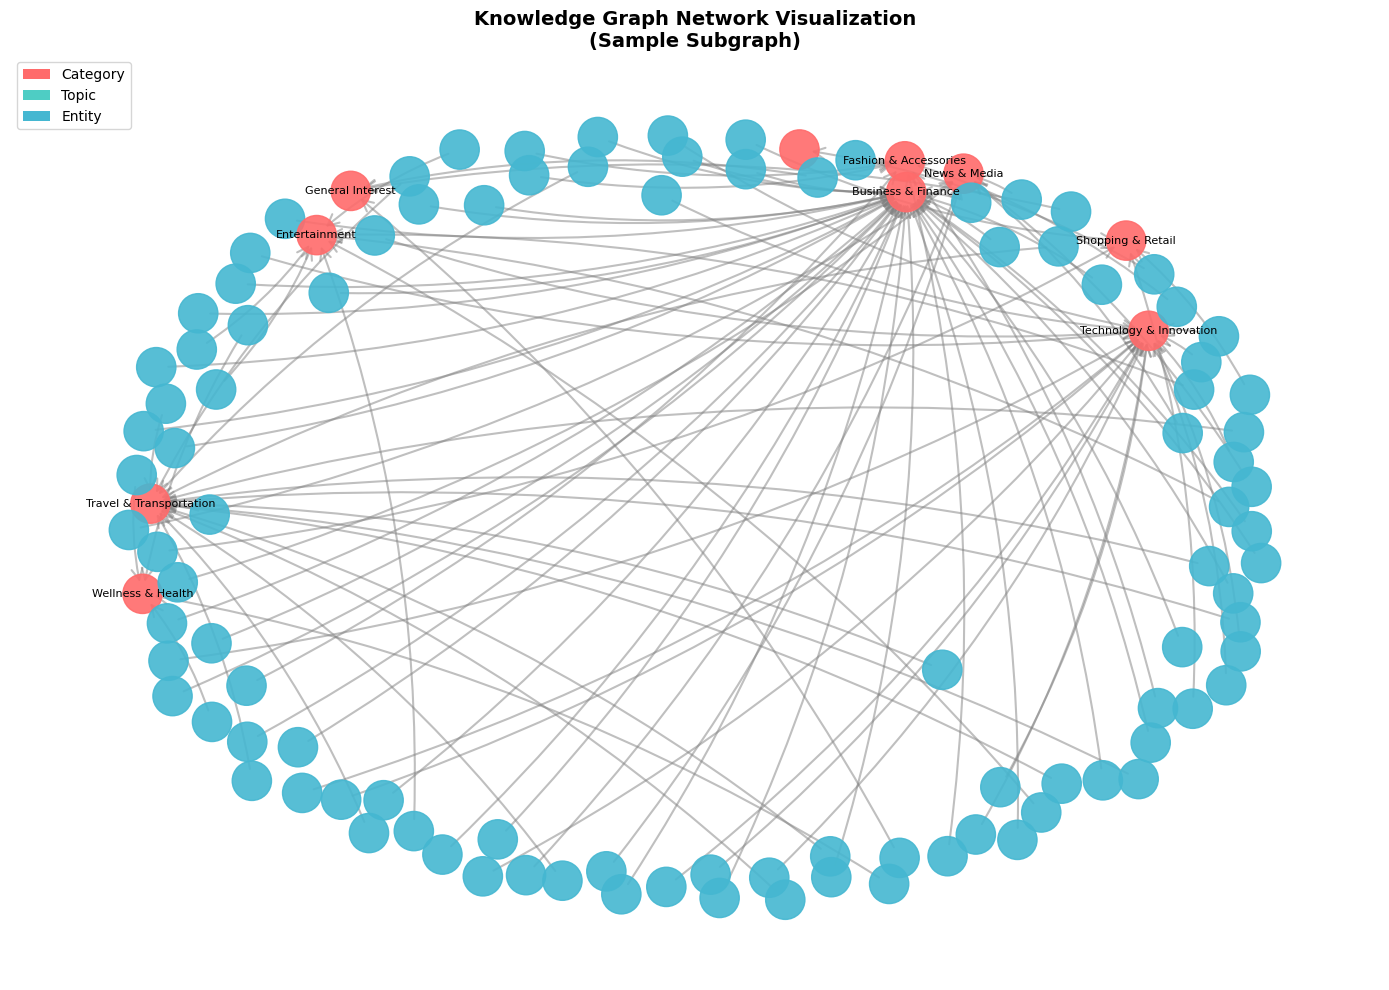

✓ Visualization complete


In [23]:
# Visualization: Create a sample network graph
if neo4j_conn:
    print("\n=== CREATING NETWORK VISUALIZATION ===\n")
    
    # Build a networkx graph
    G = nx.DiGraph()
    
    # Add sample nodes and edges from the database
    sample_query = """
    MATCH (n1)-[r]->(n2)
    WHERE labels(n1)[0] IN ['Category', 'Topic', 'Entity']
    RETURN 
        labels(n1)[0] as label1,
        coalesce(n1.name, n1.topic_id, n1.entity_id) as node1,
        labels(n2)[0] as label2,
        coalesce(n2.name, n2.topic_id, n2.entity_id) as node2,
        type(r) as relationship_type
    LIMIT 100
    """
    
    results = neo4j_conn.query(sample_query)
    
    # Build graph
    for result in results:
        node1 = result['node1']
        node2 = result['node2']
        label1 = result['label1']
        label2 = result['label2']
        
        G.add_node(node1, node_type=label1)
        G.add_node(node2, node_type=label2)
        G.add_edge(node1, node2, relationship=result['relationship_type'])
    
    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Use spring layout for visualization
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Color nodes by type
    node_colors = []
    color_map = {'Category': '#FF6B6B', 'Topic': '#4ECDC4', 'Entity': '#45B7D1'}
    for node in G.nodes():
        node_type = G.nodes[node].get('node_type', 'Unknown')
        node_colors.append(color_map.get(node_type, '#95E1D3'))
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, ax=ax, alpha=0.9)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                          arrowsize=20, arrowstyle='->', ax=ax, 
                          connectionstyle='arc3,rad=0.1', alpha=0.5, width=1.5)
    
    # Draw labels for high-degree nodes only
    high_degree_nodes = {node: node for node, degree in dict(G.degree()).items() if degree > 2}
    nx.draw_networkx_labels(G, pos, labels=high_degree_nodes, font_size=8, ax=ax)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', label='Category'),
        Patch(facecolor='#4ECDC4', label='Topic'),
        Patch(facecolor='#45B7D1', label='Entity')
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_title('Knowledge Graph Network Visualization\n(Sample Subgraph)', 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization complete")

In [24]:
# Summary and utility functions
print("\n" + "="*50)
print("KNOWLEDGE GRAPH CONSTRUCTION COMPLETE")
print("="*50)

# Define utility functions for future use
def search_by_similarity(query_text, node_type='Entity', limit=5):
    """
    Semantic search in the knowledge graph
    """
    if not neo4j_conn:
        print("Neo4j connection not available")
        return []
    
    query_embedding = get_embedding(query_text)
    
    cypher_query = f"""
    MATCH (n:{node_type})
    WHERE n.embedding IS NOT NULL
    RETURN 
        labels(n)[0] as node_type,
        coalesce(n.name, n.topic_id, n.entity_id) as node_id,
        n.embedding as embedding
    LIMIT {limit * 3}
    """
    
    results = neo4j_conn.query(cypher_query)
    
    # Calculate similarities
    similarities = []
    for result in results:
        node_embedding = np.array(result['embedding'])
        query_vec = np.array(query_embedding).reshape(1, -1)
        node_vec = node_embedding.reshape(1, -1)
        similarity = cosine_similarity(query_vec, node_vec)[0][0]
        similarities.append({
            'node_id': result['node_id'],
            'node_type': result['node_type'],
            'similarity': float(similarity)
        })
    
    # Sort and return top results
    similarities = sorted(similarities, key=lambda x: x['similarity'], reverse=True)
    return similarities[:limit]

def get_entity_connections(entity_name):
    """Get all connections for an entity"""
    if not neo4j_conn:
        print("Neo4j connection not available")
        return {}
    
    query = """
    MATCH (e:Entity {name: $name})
    OPTIONAL MATCH (e)<-[:MENTIONS]-(t:Topic)
    OPTIONAL MATCH (e)-[:CO_OCCURS_WITH]->(other:Entity)
    RETURN 
        e.name as entity,
        count(DISTINCT t) as topic_mentions,
        collect(DISTINCT other.name) as related_entities
    """
    
    result = neo4j_conn.query(query, name=entity_name)
    return result[0] if result else {}

# Example usage
print("\n📊 Available Functions:")
print("  - search_by_similarity(query_text, node_type='Entity', limit=5)")
print("  - get_entity_connections(entity_name)")
print("  - neo4j_conn.query(cypher_query)")

print("\n✨ Knowledge graph ready for exploration!")
print(f"\nAccess at: {NEO4J_URI}")
print(f"Login: {NEO4J_USER} / ****")


KNOWLEDGE GRAPH CONSTRUCTION COMPLETE

📊 Available Functions:
  - search_by_similarity(query_text, node_type='Entity', limit=5)
  - get_entity_connections(entity_name)
  - neo4j_conn.query(cypher_query)

✨ Knowledge graph ready for exploration!

Access at: bolt://localhost:7687
Login: neo4j / ****


In [25]:
search_by_similarity("blackstone")  # Example function call

[{'node_id': 'Blackstone',
  'node_type': 'Entity',
  'similarity': 1.0000000000000004},
 {'node_id': 'London',
  'node_type': 'Entity',
  'similarity': 0.38176038719202515},
 {'node_id': 'BMACX', 'node_type': 'Entity', 'similarity': 0.3189142642522439},
 {'node_id': 'Real Estate',
  'node_type': 'Entity',
  'similarity': 0.30724746762677035},
 {'node_id': 'Jon Gray',
  'node_type': 'Entity',
  'similarity': 0.2976222251059274}]

In [26]:
# Search for similar topics by semantic similarity
print("\n=== SEMANTIC TOPIC SEARCH ===\n")

# Define a search query
topic_query_text = "machine learning deep learning neural networks"
print(f"Query: '{topic_query_text}'")
print("Finding similar topics...\n")

# Use the search function but for Topics instead of Entities
topic_results = search_by_similarity(topic_query_text, node_type='Topic', limit=10)

print("Top 10 similar topics:")
for i, result in enumerate(topic_results, 1):
    print(f"{i}. {result['node_id']}: {result['similarity']:.4f}")

# You can also search with other queries:
print("\n" + "="*60)
print("Another example - searching for finance-related topics:")
finance_results = search_by_similarity("stock market investment finance banking", node_type='Topic', limit=5)
for i, result in enumerate(finance_results, 1):
    print(f"{i}. {result['node_id']}: {result['similarity']:.4f}")


=== SEMANTIC TOPIC SEARCH ===

Query: 'machine learning deep learning neural networks'
Finding similar topics...

Top 10 similar topics:
1. cluster_23_topic_gaussian_mixture_model: 0.2090
2. cluster_20_topic_skyscanner: 0.1841
3. cluster_0_topic_gmail: 0.1600
4. cluster_18_topic_chris_martin: 0.1594
5. cluster_5_topic_unknown: 0.1583
6. cluster_8_topic_unknown: 0.1583
7. cluster_16_topic_unknown: 0.1583
8. cluster_21_topic_unknown: 0.1583
9. cluster_26_topic_unknown: 0.1583
10. cluster_29_topic_unknown: 0.1583

Another example - searching for finance-related topics:
1. cluster_1_topic_investment_banking_networking_events: 0.5720
2. cluster_7_topic_valuation: 0.2631
3. cluster_3_topic_blackstone_homepage_/_alternative_asset_: 0.2305
4. cluster_14_topic_dai_price: 0.1667
5. cluster_12_topic_maplin_canary_wharf_location: 0.1291


In [33]:
# Deep dive: Get detailed topic information with similarity
print("\n=== DETAILED TOPIC SIMILARITY ANALYSIS ===\n")

# Search for topics and get their full details
def search_topics_detailed(query_text, limit=5):
    """Search for topics and return detailed information including content"""
    
    # Get top similar topics
    results = search_by_similarity(query_text, node_type='Topic', limit=limit)
    
    # Fetch detailed information for each topic
    detailed_results = []
    for result in results:
        topic_query = """
        MATCH (t:Topic {topic_id: $topic_id})
        OPTIONAL MATCH (t)-[:BELONGS_TO]->(c:Category)
        OPTIONAL MATCH (t)-[:MENTIONS]->(e:Entity)
        RETURN 
            t.topic_id as topic_id,
            t.content as content,
            c.name as category,
            count(DISTINCT e) as entity_count,
            collect(DISTINCT e.name) as entities
        """
        try:
            topic_details = neo4j_conn.query(topic_query, topic_id=result['node_id'])
            if topic_details:
                detail = topic_details[0]
                detail['similarity'] = result['similarity']
                detailed_results.append(detail)
        except:
            pass
    
    return detailed_results

# Example usage
search_query = "shoes"
detailed_topics = search_topics_detailed(search_query, limit=10)

print(f"Query: '{search_query}'\n")
for i, topic in enumerate(detailed_topics, 1):
    print(f"{i}. {topic['topic_id']} (Similarity: {topic['similarity']:.4f})")
    print(f"   Content: {topic['content'][:80]}...")
    print(f"   Category: {topic['category']}")
    print(f"   Entities mentioned: {topic['entity_count']}")
    if topic['entities']:
        print(f"   Entities: {', '.join(topic['entities'][:3])}")
    print()


=== DETAILED TOPIC SIMILARITY ANALYSIS ===

Query: 'shoes'

1. cluster_15_topic_jazz (Similarity: 0.3106)
   Content: Jazz...
   Category: Entertainment
   Entities mentioned: 0

2. cluster_5_topic_unknown (Similarity: 0.2785)
   Content: Unknown...
   Category: Uncategorized
   Entities mentioned: 1
   Entities: unknown

3. cluster_8_topic_unknown (Similarity: 0.2785)
   Content: Unknown...
   Category: Uncategorized
   Entities mentioned: 1
   Entities: unknown

4. cluster_16_topic_unknown (Similarity: 0.2785)
   Content: Unknown...
   Category: Uncategorized
   Entities mentioned: 1
   Entities: unknown

5. cluster_21_topic_unknown (Similarity: 0.2785)
   Content: Unknown...
   Category: Uncategorized
   Entities mentioned: 1
   Entities: unknown

6. cluster_26_topic_unknown (Similarity: 0.2785)
   Content: Unknown...
   Category: Uncategorized
   Entities mentioned: 1
   Entities: unknown

7. cluster_29_topic_unknown (Similarity: 0.2785)
   Content: Unknown...
   Category: Uncateg

In [ ]:
# Get top 5 similar topics with complete details
print("\n=== TOP 5 SIMILAR TOPICS WITH FULL DETAILS ===\n")

query_text = "artificial intelligence machine learning"
# query_text = "bollywood"

print(f"Search Query: '{query_text}'\n")
print("="*80)

# Get top 5 similar topics
top_5_topics = search_topics_detailed(query_text, limit=5)

for idx, topic in enumerate(top_5_topics, 1):
    print(f"\n#{idx} - Topic ID: {topic['topic_id']}")
    print(f"    Similarity Score: {topic['similarity']:.4f}")
    print(f"    Category: {topic['category']}")
    print(f"    Content: {topic['content']}")
    if topic['entities'] and len(topic['entities']) > 0:
        print(f"    Related Entities: {', '.join(topic['entities'])}")
    print("-"*80)

print("\n✓ Top 5 similar topics retrieved successfully")


=== TOP 5 SIMILAR TOPICS WITH FULL DETAILS ===

Search Query: 'artificial intelligence machine learning'


#1 - Topic ID: cluster_0_topic_gmail
    Similarity Score: 0.2048
    Category: Technology & Innovation
    Content: Gmail
    Related Entities: Gmail
--------------------------------------------------------------------------------

#2 - Topic ID: cluster_5_topic_unknown
    Similarity Score: 0.2002
    Category: Uncategorized
    Content: Unknown
    Related Entities: unknown
--------------------------------------------------------------------------------

#3 - Topic ID: cluster_8_topic_unknown
    Similarity Score: 0.2002
    Category: Uncategorized
    Content: Unknown
    Related Entities: unknown
--------------------------------------------------------------------------------

#4 - Topic ID: cluster_6_topic_finding_emails_on_data.com
    Similarity Score: 0.1560
    Category: Technology & Innovation
    Content: Finding emails on data.com
    Related Entities: emails, Data, 

In [30]:
# View the unified categories from both data sources
print("===  CATEGORIES FROM DATA SOURCE ===\n")
for i, (cat_id, cat_data) in enumerate(all_categories.items(), 1):
    print(f"{i}. {cat_data['name']}")
    print(f"   - Source: {cat_data['source']}")
    print(f"   - Activities: {cat_data.get('activity_count', 0)}")
    print(f"   - Searches: {cat_data.get('search_count', 0)}")
    # Count topics for this category
    topic_count = sum(1 for t in all_topics.values() if t.get('category') == cat_data['name'])
    print(f"   - Topics: {topic_count}")
    print()

===  CATEGORIES FROM DATA SOURCE ===

1. Technology & Innovation
   - Source: cluster_summaries
   - Activities: 4649
   - Searches: 0
   - Topics: 4637

2. Business & Finance
   - Source: cluster_summaries
   - Activities: 3382
   - Searches: 0
   - Topics: 3379

3. General Interest
   - Source: cluster_summaries
   - Activities: 2628
   - Searches: 0
   - Topics: 2628

4. Uncategorized
   - Source: cluster_summaries
   - Activities: 8967
   - Searches: 0
   - Topics: 8967

5. Travel & Transportation
   - Source: cluster_summaries
   - Activities: 2352
   - Searches: 0
   - Topics: 2352

6. Shopping & Retail
   - Source: cluster_summaries
   - Activities: 2173
   - Searches: 0
   - Topics: 2172

7. Wellness & Health
   - Source: cluster_summaries
   - Activities: 2719
   - Searches: 0
   - Topics: 2719

8. Entertainment
   - Source: cluster_summaries
   - Activities: 1581
   - Searches: 0
   - Topics: 1581

9. News & Media
   - Source: cluster_summaries
   - Activities: 1512
   - Sear